<a href="https://colab.research.google.com/github/ClementBM/Experiment_DeepLearning_Moonboard_Grade-Prediction/blob/master/LSTM_BoulderProblem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import some relevant packages

In [1]:
from sklearn.utils import shuffle
from torch.utils.data import DataLoader
import torch
from tqdm import tqdm

from climbing_ai.moonboard_dataset import (MoonboardDataset, 
                                           data_preprocessing,
                                           extract_batch,
                                           data_2016_preprocessing)
from climbing_ai.moonboard_tokenizer import MoonboardTokenizer
from climbing_ai.moonboard_evaluation import evaluate, plot_confusion_matrix, predict, calculate_metrics
from climbing_ai.lstm_simple import LSTMModel

N_LAYERS = 3
DROPOUT = 0.1
EMBED_DIM = 60

IGNORE_INDEX = -100

EVAL_ITERS = 10
MAX_ITERS = 10000
EVAL_INTERVAL = 1000
LEARNING_RATE = 1e-3
EPOCHS = 300

BATCH_SIZE = 64 # how many independent sequences will we process in parallel?

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

# Define tokenizer

In [2]:
tokenizer = MoonboardTokenizer(
    horizontal_count=11,
    vertical_count=18,
    horizontal_spacing=50,
    vertical_spacing=50,
)

# Load and parse data

In [3]:
# dataset = data_preprocessing()
dataset = data_2016_preprocessing(tokenizer)

shuffled_dataset = shuffle(dataset, random_state=42)

# Keep 90% for training, 10% for validation
split = int(0.9 * len(dataset))

train_ds = shuffled_dataset[:split]
eval_ds = shuffled_dataset[split:]

all_dataset = MoonboardDataset(dataset=dataset, tokenizer=tokenizer)
selected_grades = [k for k, v in all_dataset.grade_freq.items() if v > 30]

train_dataset = MoonboardDataset(dataset=train_ds, tokenizer=tokenizer, 
                                 max_len=all_dataset.max_len, selected_grades=selected_grades)

eval_dataset = MoonboardDataset(dataset=eval_ds, tokenizer=tokenizer, 
                                max_len=all_dataset.max_len, selected_grades=selected_grades)


train_dataset.filter_by_grade(selected_grades)
eval_dataset.filter_by_grade(selected_grades)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
eval_dataloader = DataLoader(eval_dataset, batch_size=1, shuffle=True)

# Building the model
Here we define the LSTM RNN

```python
model.add(Activation("linear"))
model.compile(loss='mae', optimizer='adam')
```

In [4]:
model = LSTMModel(input_dim=tokenizer.get_vocab_size(),
                  hidden_dim=EMBED_DIM,
                  layer_dim=N_LAYERS,
                  output_dim=len(selected_grades),
                  embedding_dim=EMBED_DIM,
                  max_len=all_dataset.max_len).to(DEVICE)

# Loss function
loss_fn_lm = torch.nn.CrossEntropyLoss()

# Optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)


In [5]:
epoch_iterator = tqdm(range(1))
model.train()

for epoch in epoch_iterator:
    for batch in train_dataloader:
        optimizer.zero_grad()

        (
            input_ids,
            input_locations,
            masked_input_ids,
            masked_token_ids,
            masked_positions,
            attention_mask,
            grade_id,
            sequence_length,
        ) = extract_batch(batch, DEVICE)

        outputs = model(input_ids, sequence_length)
        loss = loss_fn_lm(outputs, grade_id)

        epoch_iterator.set_postfix({"loss": f"{loss.item():6.3f}"})
        
        loss.backward()
        optimizer.step()

100%|██████████| 1/1 [00:06<00:00,  6.43s/it, loss=1.457]


# Evaluate
* We make predictions on the test set rounding the predicted grade floating number.
* We then calculate the related MAE based on these prediction.
* The grade error is shown in the heat map.
* The absolute error is shown in the histogram.

In [6]:
def call_model(compressed_batch, model):
    (
        input_ids,
        input_locations,
        masked_input_ids,
        masked_token_ids,
        masked_positions,
        attention_mask,
        grade_id,
        sequence_length,
    ) = compressed_batch

    logits_clsf = model(input_ids, sequence_length)
    return logits_clsf

predictions, truths, probabilities = predict(model=model,
         call_model=call_model,
         dataloader=eval_dataloader,
         device=DEVICE)

In [7]:
calculate_metrics(truths, predictions, probabilities)

ROC AUC: 0.811054
Accuracy: 0.410072


/home/clem/Source/climbing-moonboard-ai/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Precision: 0.346599
Recall: 0.410072
F1 score: 0.353209


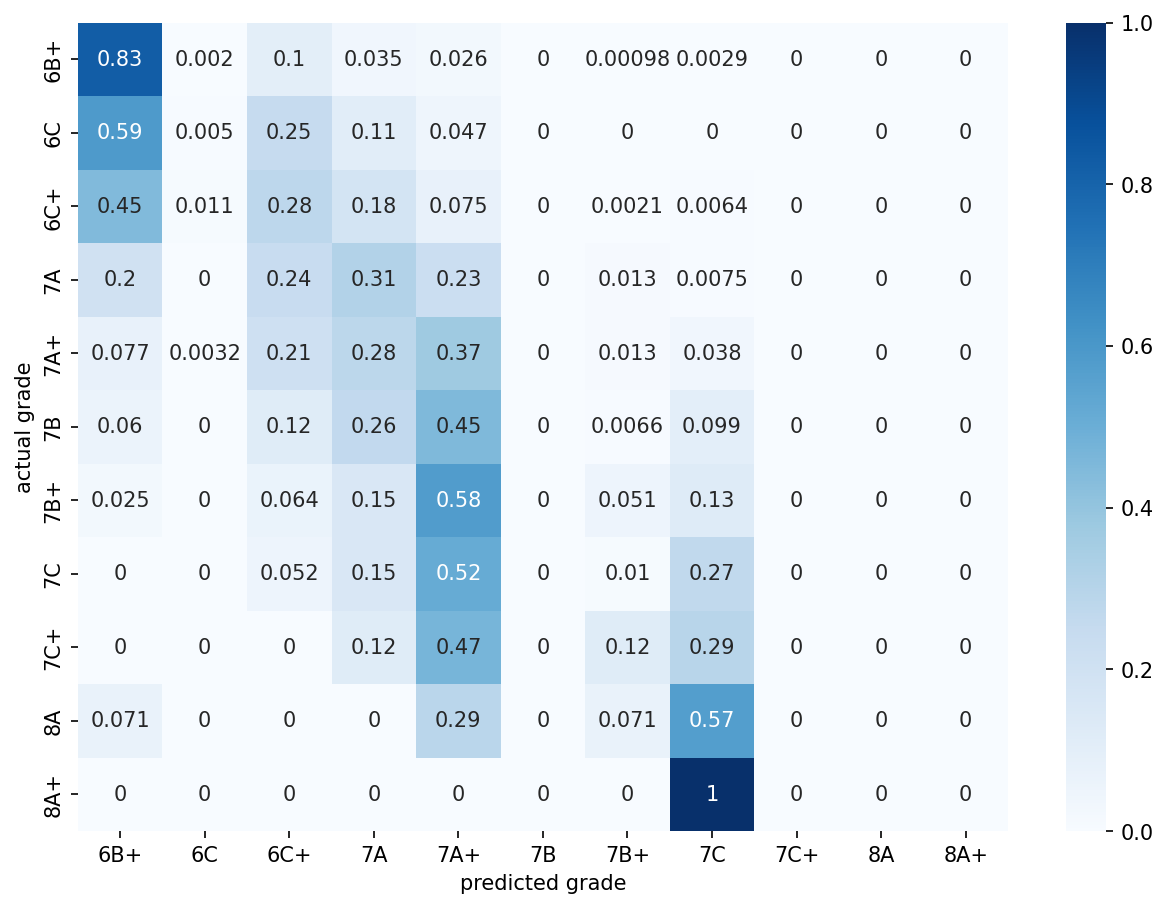

In [8]:
plot_confusion_matrix(truths, predictions, selected_grades)

/home/clem/Source/climbing-moonboard-ai/climbing_ai/moonboard_evaluation.py:110: RuntimeWarning: invalid value encountered in divide
  errorByGradeNorm = error_by_grade / errorByGradeRowSums[:, np.newaxis]


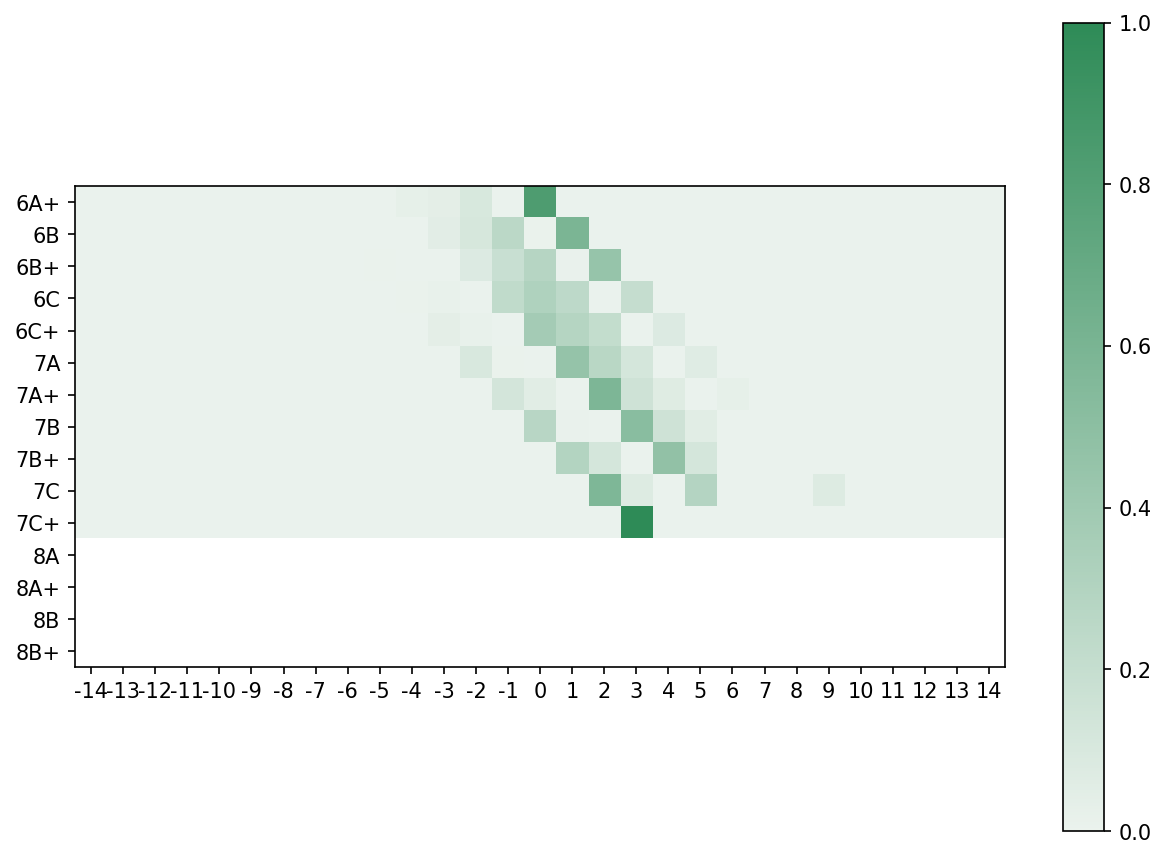

MAE = 1.100392460823059
Correctness Count = {0} : [41.01%] + {1} : [26.23%] = 67.23%
First Bound Grade Error Count = {2} : [20.34%] + {3} : [8.18%] = 28.52%
Second Bound Grade Error Count = {4} : [3.14%] + {5} : [0.82%] + {6} : [0.16%] = 4.12%


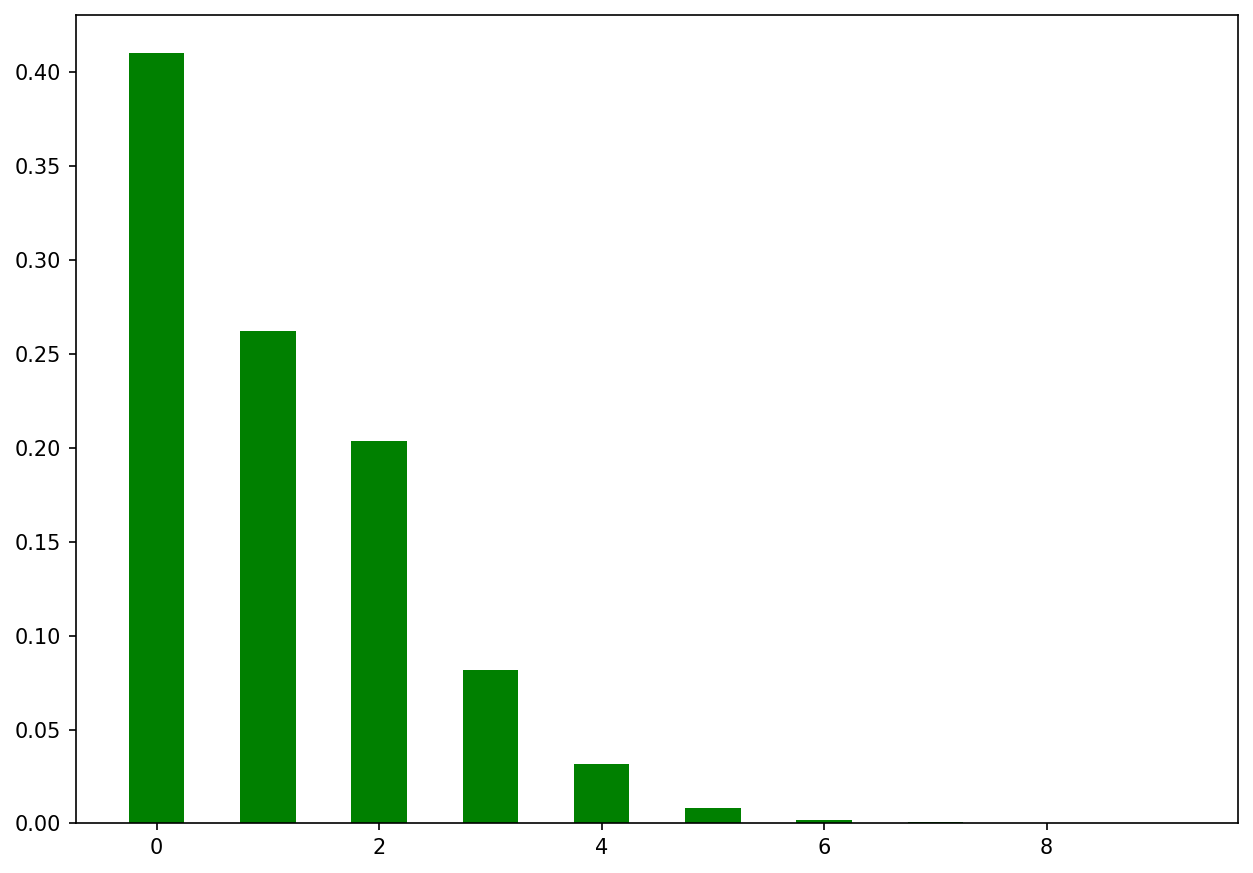

In [9]:
evaluate(model=model,
         call_model=call_model,
         dataloader=eval_dataloader,
         device=DEVICE)